# Multilabel Disease Classification from Chest X-Ray Images (Kaggle NIH Chest X-Ray Dataset)
UC San Diego - Machine Learning Bootcamp - October 2021 Cohort

Tung Nguyen

---
## Kaggle Dataset Description
National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)


Data limitations:

The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
Very limited numbers of disease region bounding boxes (See BBoxlist2017.csv)
Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


---
## General Observations & Notes
- This is a multilabel classification problem; for each image, multiple labels could apply (each label corresponding to a single lung complication).
- The "Finding Labels" column is the target, and will need to be converted to multiple columns of binary values.
- Additional tabular data is also provided about a Patient's Follow-Up (e.g. how many times they've previously been examined), Age, and Gender.
- The "View Position" column also provides context as to how the image was taken. 

## Potential Issues
- Since there are multiple "View Positions", the images may need to be reversed so that left-hand-side and right-hand-side are the same for every picture. For details, refer to: https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection
- Reading through the dataset notes, the label "No Finding" only indicates that the 14 diseases which were studied are not present. Namely, "No Finding" does not necessarily equate to "No Disease", but could still correspond to a disease outside of the 14 studied.

---
## Exploratory Data Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
df = pd.read_csv('/Volumes/T7/mec-capstone-data/nih-chest-x-ray/Data_Entry_2017.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x','y]', 'Unnamed: 11'], axis=1, inplace=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


In [4]:
df.dtypes

Image Index       object
Finding Labels    object
Follow-up #        int64
Patient ID         int64
Patient Age        int64
Patient Gender    object
View Position     object
dtype: object

In [5]:
df.isnull().sum()

Image Index       0
Finding Labels    0
Follow-up #       0
Patient ID        0
Patient Age       0
Patient Gender    0
View Position     0
dtype: int64

- No null values anywhere, which is good!

In [6]:
df[['Follow-up #', 'Patient Age']].describe()

,Follow-up #,Patient Age
count,112120.000000,112120.000000
mean,8.573751,46.901463
std,15.406320,16.839923
min,0.000000,1.000000
25%,0.000000,35.000000
50%,3.000000,49.000000
75%,10.000000,59.000000
max,183.000000,414.000000


In [7]:
df['Finding Labels'].value_counts(ascending=False)[:10]

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: Finding Labels, dtype: int64

In [8]:
df_ml = df[df['Finding Labels'].str.split('|').apply(lambda x: len(x)) > 2]
df_ml['Finding Labels'].value_counts(ascending=False)[:10]

Atelectasis|Effusion|Infiltration         737
Atelectasis|Consolidation|Effusion        200
Edema|Infiltration|Pneumonia              137
Consolidation|Effusion|Infiltration       134
Edema|Effusion|Infiltration               127
Cardiomegaly|Effusion|Infiltration        120
Effusion|Infiltration|Nodule              106
Atelectasis|Consolidation|Infiltration    104
Effusion|Infiltration|Mass                 99
Atelectasis|Effusion|Pneumothorax          99
Name: Finding Labels, dtype: int64

- It seems that Atelectasis, Effusion, and Infiltration are the most common complications, and also tend to occur in the same patient often (one complication may be more likely to cause another)

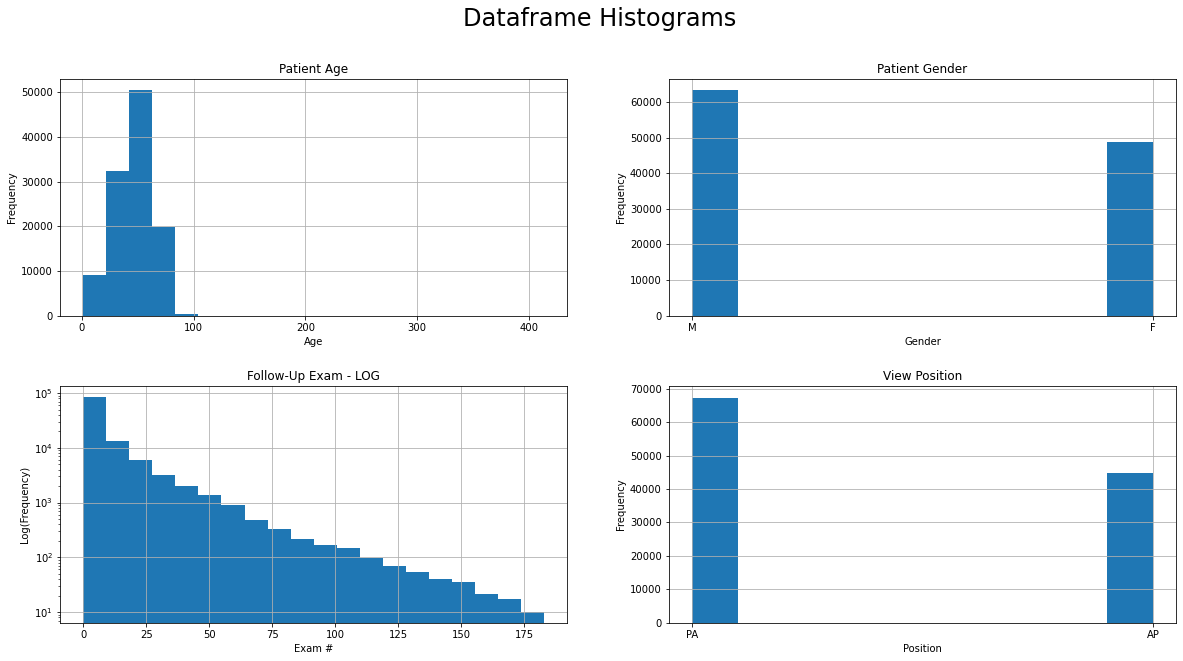

In [9]:
fig, axes = plt.subplots(2, 2, figsize=[20, 10])

fig.subplots_adjust(hspace=0.3)

fig.suptitle('Dataframe Histograms', fontsize=24)

df['Patient Age'].hist(ax=axes[0, 0], bins=20)
axes[0, 0].title.set_text('Patient Age');
axes[0, 0].set_xlabel('Age');
axes[0, 0].set_ylabel('Frequency');

df['Patient Gender'].hist(ax=axes[0, 1])
axes[0, 1].title.set_text('Patient Gender');
axes[0, 1].set_xlabel('Gender');
axes[0, 1].set_ylabel('Frequency');

df['Follow-up #'].hist(ax=axes[1, 0], log=True, bins=20)
axes[1, 0].title.set_text('Follow-Up Exam - LOG');
axes[1, 0].set_xlabel('Exam #');
axes[1, 0].set_ylabel('Log(Frequency)');

df['View Position'].hist(ax=axes[1, 1])
axes[1, 1].title.set_text('View Position');
axes[1, 1].set_xlabel('Position');
axes[1, 1].set_ylabel('Frequency');

### Data Wrangling required - fix typos in Patient Age column
- As shown in the top left histogram above, there are some patients whose reported age is >100, e.g. these are erroneous data points.
- For all patients aged 100 and greater, replace with the mean of the ages from the same patient ID.
- Age 100 is chosen arbitrarily as the limit for erroneous data points.
- If there's only one data point for the patient ID, drop the row to not skew the data.

In [10]:
err = df[df['Patient Age'] > 100]
err.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP
46965,00011973_002.png,Edema,2,11973,414,M,AP
48284,00012238_010.png,No Finding,10,12238,148,M,PA
55742,00013950_000.png,No Finding,0,13950,148,M,PA
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA


In [11]:
df_dropped = df[df['Patient Age'] < 100]

In [12]:
for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

In [13]:
df[df['Patient ID'] == 5567].head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
20852,00005567_000.png,Effusion|Pneumonia,0,5567,51,M,AP
20853,00005567_001.png,Effusion,1,5567,53,M,AP
20854,00005567_002.png,Atelectasis|Effusion|Pneumonia,2,5567,53,M,AP
20855,00005567_003.png,Infiltration,3,5567,53,M,AP
20856,00005567_004.png,Atelectasis,4,5567,54,M,PA


- As shown above, the erroneous age of 412 in Patient ID 5567 has been corrected to the mean age of 51.

In [14]:
df[df['Patient Age'] == -1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
78795,00019346_000.png,Infiltration,0,19346,-1,F,PA
101194,00026871_000.png,No Finding,0,26871,-1,F,PA
104590,00027989_000.png,No Finding,0,27989,-1,M,PA


In [15]:
dff = df[df['Patient Age'] != -1]

In [16]:
dff.shape

(112117, 7)

- There are 3 observations that did not get fixed because there were no other data points available to calculate a mean. 
- Since this is a small number of points relative to the whole dataset, it is OK to drop the data points
- Updated histogram are shown below.

---
## Data Exploration - Wrangled Data
Updated the data exploration from the previous section with the latest, filtered data frame.

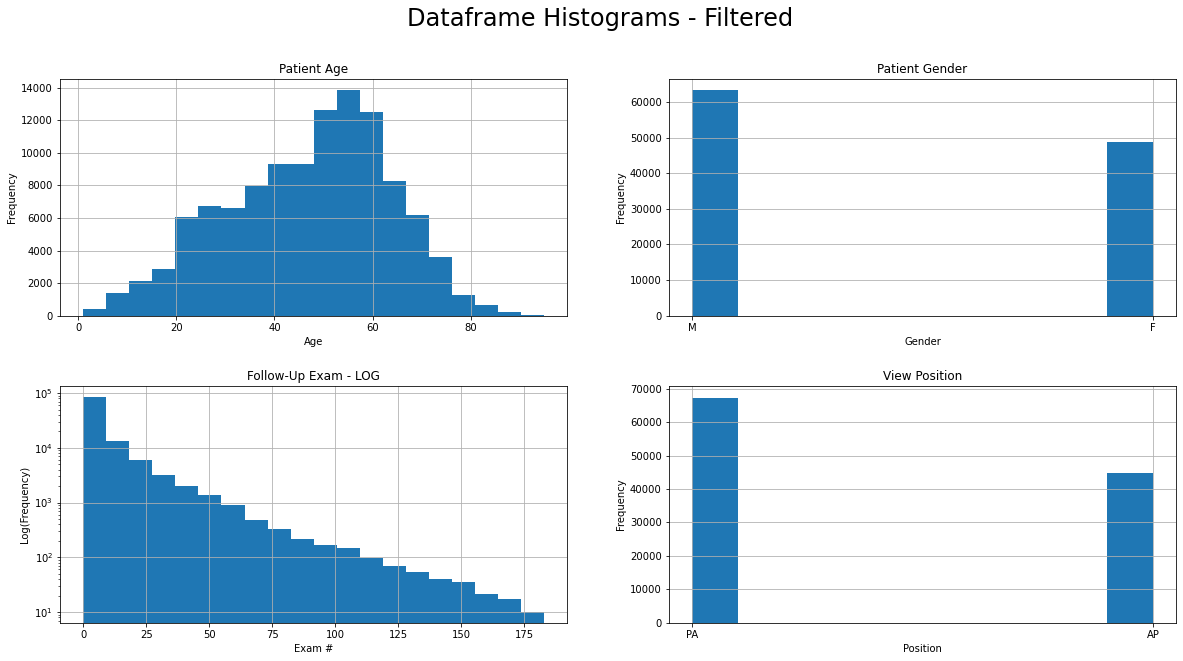

In [17]:
fig, axes = plt.subplots(2, 2, figsize=[20, 10])

fig.subplots_adjust(hspace=0.3)
fig.suptitle('Dataframe Histograms - Filtered', fontsize=24)

dff['Patient Age'].hist(ax=axes[0, 0], bins=20)
axes[0, 0].title.set_text('Patient Age');
axes[0, 0].set_xlabel('Age');
axes[0, 0].set_ylabel('Frequency');

dff['Patient Gender'].hist(ax=axes[0, 1])
axes[0, 1].title.set_text('Patient Gender');
axes[0, 1].set_xlabel('Gender');
axes[0, 1].set_ylabel('Frequency');

dff['Follow-up #'].hist(ax=axes[1, 0], log=True, bins=20)
axes[1, 0].title.set_text('Follow-Up Exam - LOG');
axes[1, 0].set_xlabel('Exam #');
axes[1, 0].set_ylabel('Log(Frequency)');

dff['View Position'].hist(ax=axes[1, 1])
axes[1, 1].title.set_text('View Position');
axes[1, 1].set_xlabel('Position');
axes[1, 1].set_ylabel('Frequency');

In [18]:
dff[['Follow-up #', 'Patient Age']].describe()

,Follow-up #,Patient Age
count,112117.000000,112117.000000
mean,8.573981,46.872892
std,15.406462,16.598099
min,0.000000,1.000000
25%,0.000000,35.000000
50%,3.000000,49.000000
75%,10.000000,59.000000
max,183.000000,95.000000


- Erroneous data points had a negligible impact on the patient age statistics.

---
## Data Wrangling - Convert the 'Finding Label' column to binary values using sklearn

In [19]:
mlb = MultiLabelBinarizer()
temp = mlb.fit_transform(dff['Finding Labels'].str.split("|"))

In [20]:
temp

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [22]:
df_mlb = pd.DataFrame(temp, columns=mlb.classes_)
df_mlb.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
mdf = dff.join(df_mlb)

In [24]:
mdf.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
## Data Exploration - Frequency of Diseases

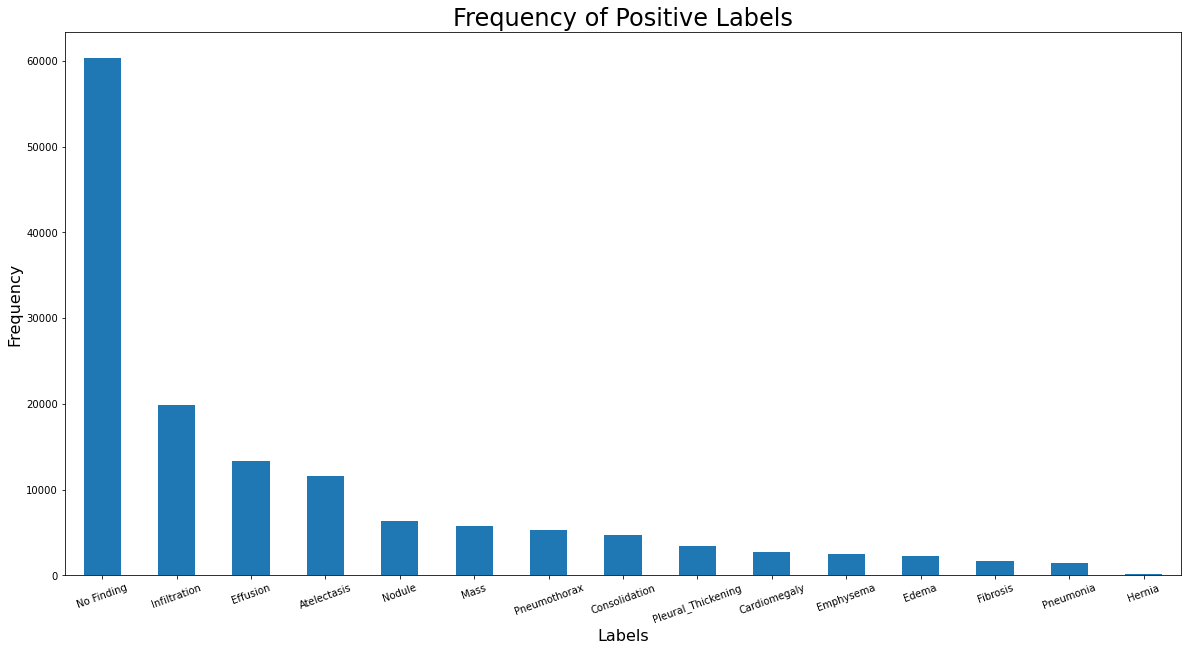

In [25]:
df_agg = df_mlb.sum().sort_values(ascending=False)

fig = df_agg.plot(kind='bar', figsize=(20, 10), rot=20);
fig.set_title('Frequency of Positive Labels', fontsize=24);
fig.set_xlabel('Labels', fontsize=16);
fig.set_ylabel('Frequency', fontsize=16);

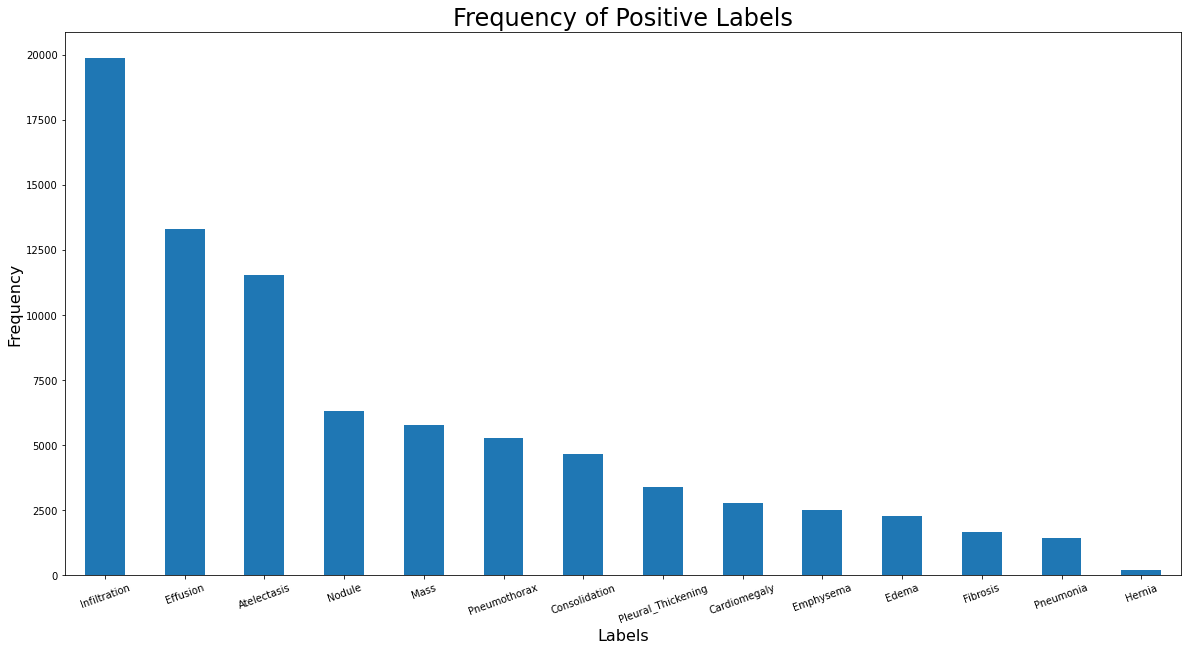

In [26]:
df_agg = df_mlb.sum().sort_values(ascending=False)[1:]

fig = df_agg.plot(kind='bar', figsize=(20, 10), rot=20);
fig.set_title('Frequency of Positive Labels', fontsize=24);
fig.set_xlabel('Labels', fontsize=16);
fig.set_ylabel('Frequency', fontsize=16);

In [27]:
print('Number of "No Finding" labels = {}'.format(df_agg[0]))
print('Number of Disease labels = {}'.format(sum(df_agg[1:])))

Number of "No Finding" labels = 19893
Number of Disease labels = 61282


### Observations & Notes
- The dataset is well distributed between positive and negative observations, meaning there are equal amounts of "No Finding" labels vs. disease labels
- Within the disease labels, there is some variation in the distribution which could present some challenges.
- For example, there are very few data points for 'Hernia'. The classification model could be biased against more frequent diseases.

---
## Data Exploration - Investigating Correlation between Age/Gender & Disease

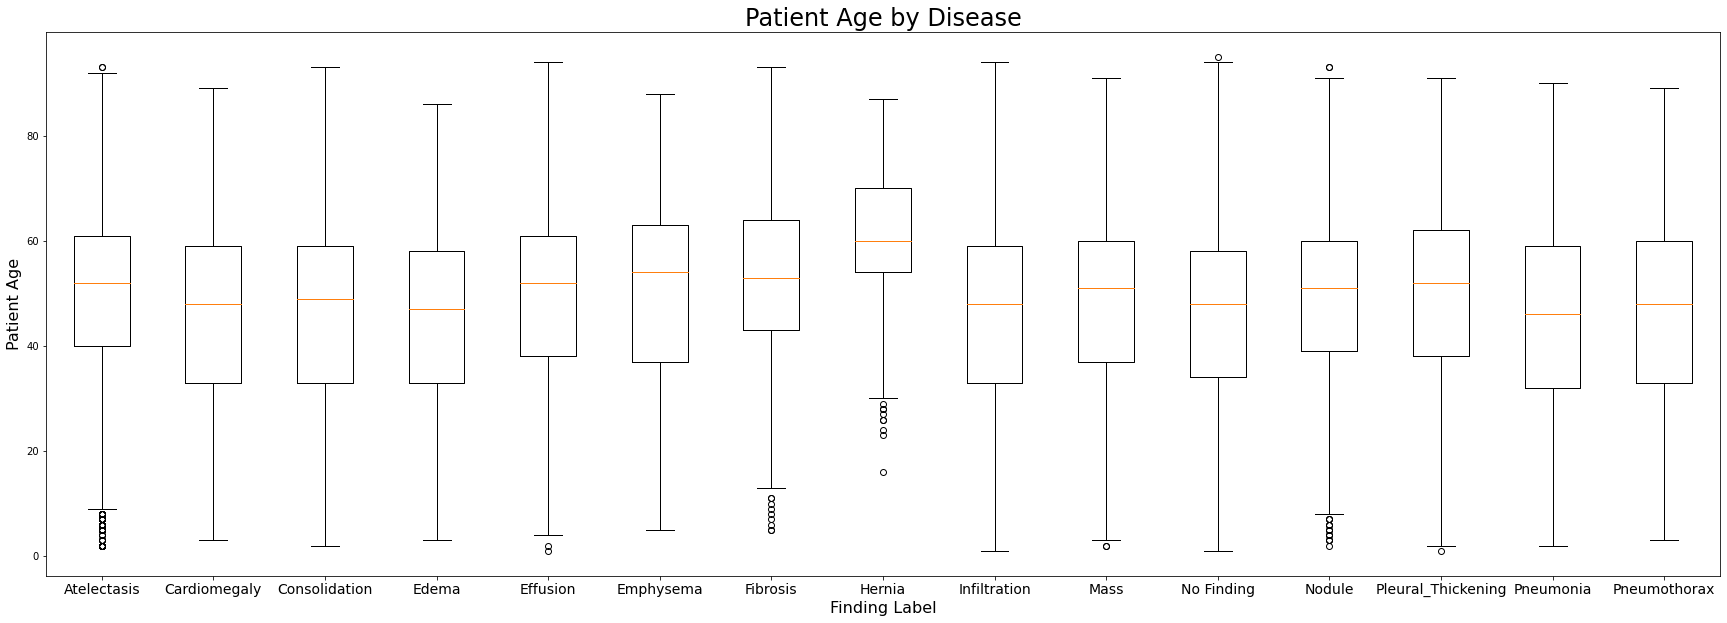

In [28]:
data = []
M = []
F = []
for label in mlb.classes_:
    data.append(mdf[mdf[label] == 1]['Patient Age'])
    M.append(mdf[mdf[label] == 1]['Patient Gender'].value_counts()[0])
    F.append(mdf[mdf[label] == 1]['Patient Gender'].value_counts()[1])

fig, ax = plt.subplots(figsize=(30,10))
ax.boxplot(data);
ax.set_xticklabels(mlb.classes_, fontsize=14);
ax.set_title('Patient Age by Disease', fontsize=24);
ax.set_xlabel('Finding Label', fontsize=16);
ax.set_ylabel('Patient Age', fontsize=16);

In [29]:
print(M)

[6831, 1430, 2681, 1209, 7446, 1608, 905, 128, 11361, 3509, 33968, 3682, 2037, 837, 2735]


In [30]:
print(F)

[4728, 1346, 1986, 1094, 5871, 908, 781, 99, 8531, 2273, 26389, 2649, 1348, 594, 2567]


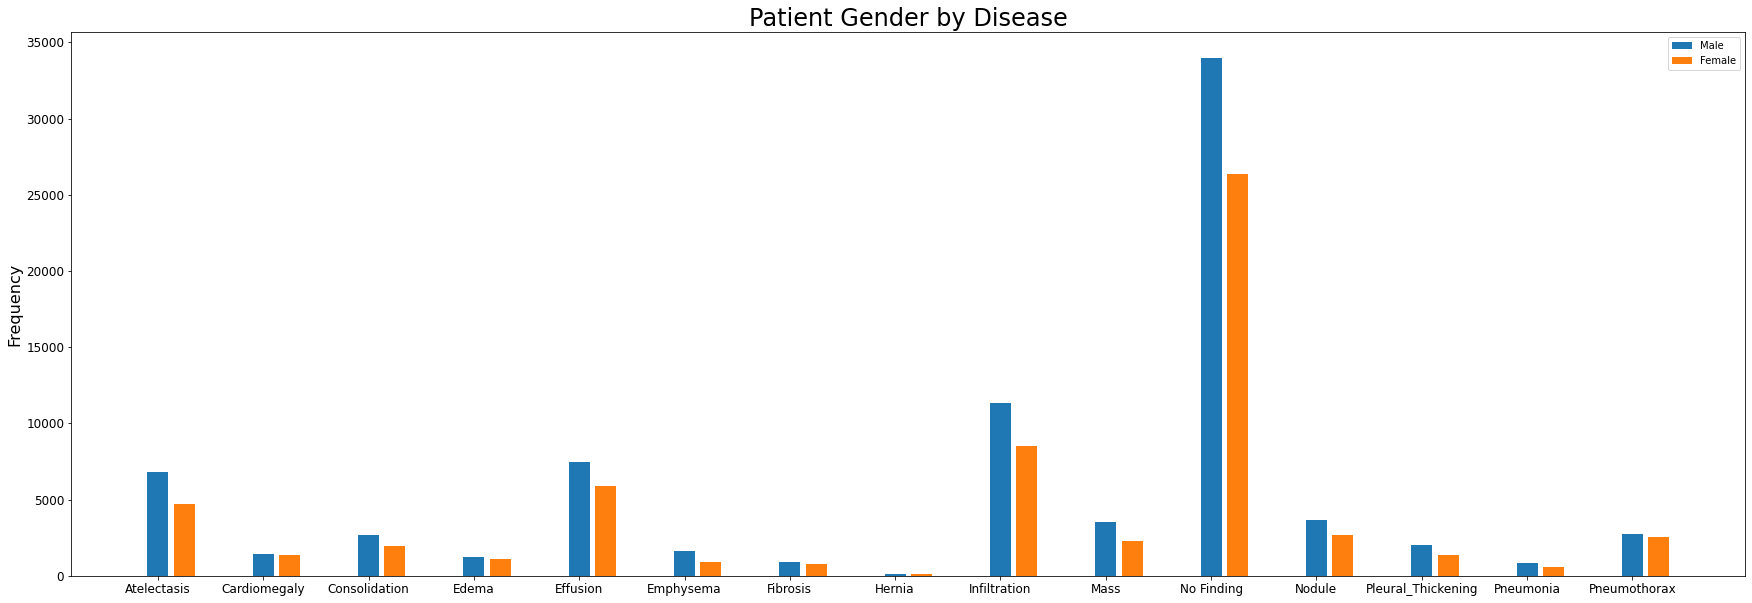

In [31]:
fig, axes = plt.subplots(figsize=(30, 10))
ind = np.arange(15)

plt.bar(x=ind, height=M, width=0.2, label='Male')
plt.bar(x=ind+0.25, height=F, width=0.2, label='Female')
plt.legend();
plt.xticks(ind, mlb.classes_, fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('Frequency', fontsize=16);
plt.title('Patient Gender by Disease', fontsize=24);

### Observations & Notes
- Looking at the box plot of patient age, it is clear that lung complications **can** appear in patients of all ages, but are most common in patients around age ~50 for all studied diseases. 
- The dataset is well distributed by gender, meaning there are equal amounts of male patients as female patients for each given label.

---
## Example Chest X-Ray Images

In [32]:
data_path = '/Volumes/T7/mec-capstone-data/nih-chest-x-ray/data/'

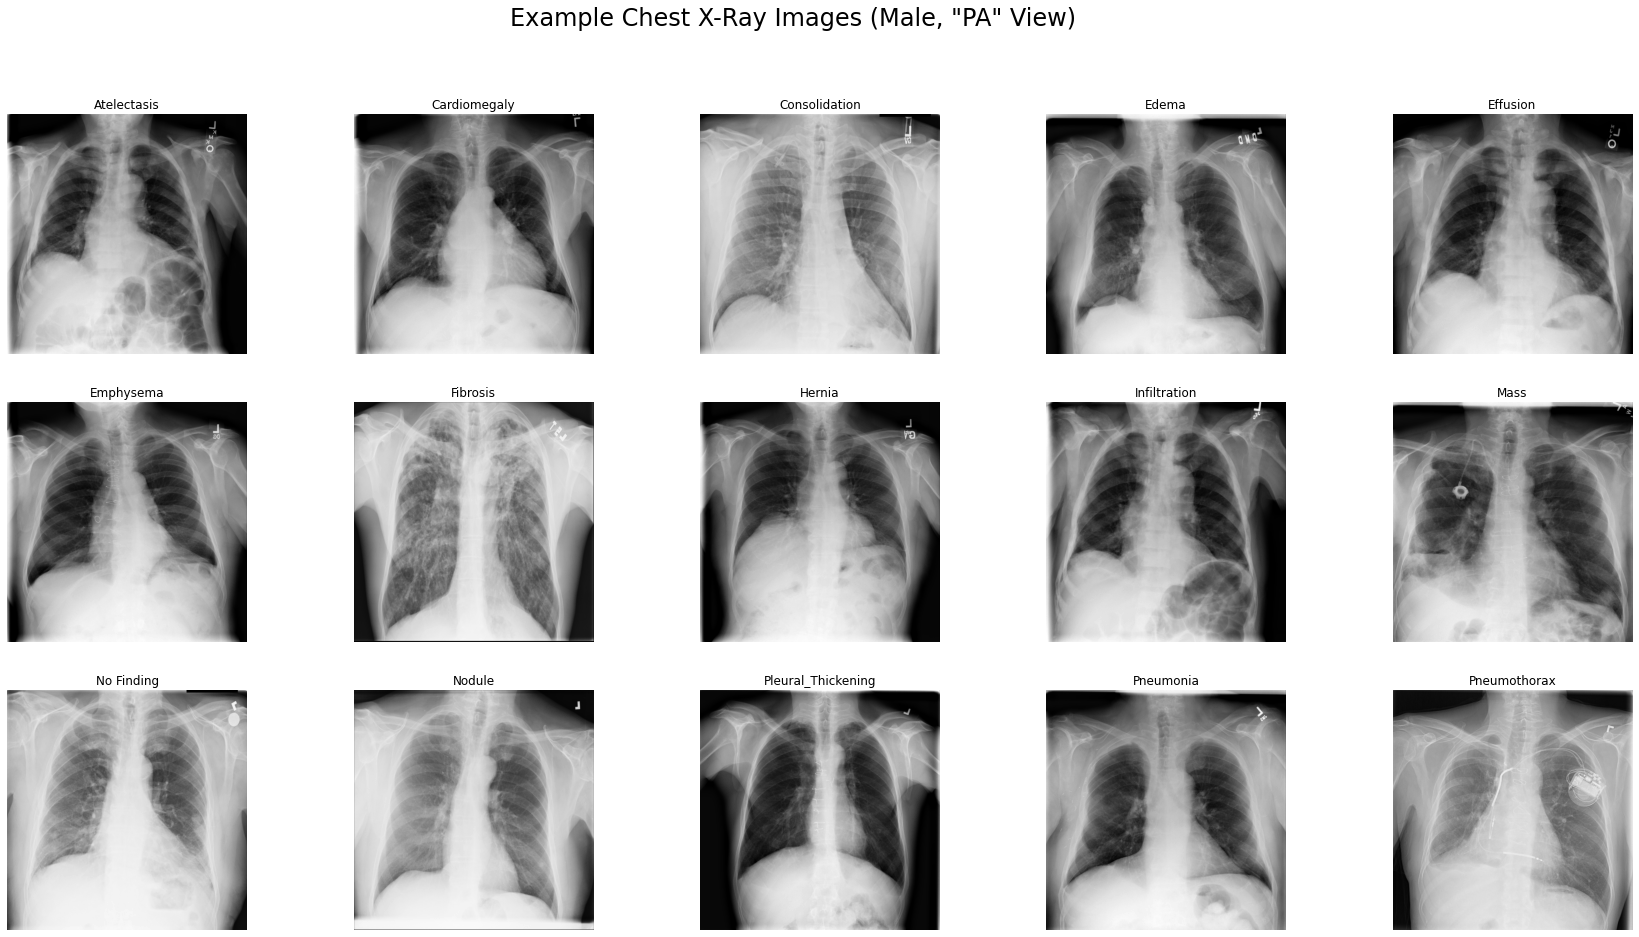

In [33]:
fig, axes = plt.subplots(3, 5, figsize=(30, 15))
axes = axes.ravel()
fig.suptitle('Example Chest X-Ray Images (Male, "PA" View)', fontsize=24)

i = 0
for label in mlb.classes_:
    img_id = mdf[(mdf['Finding Labels'] == label) & (mdf['View Position'] == 'PA') & (mdf['Patient Gender'] == 'M')]['Image Index'].iloc[0]
    xray = img.imread(data_path + img_id)
    axes[i].imshow(xray, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
    i += 1

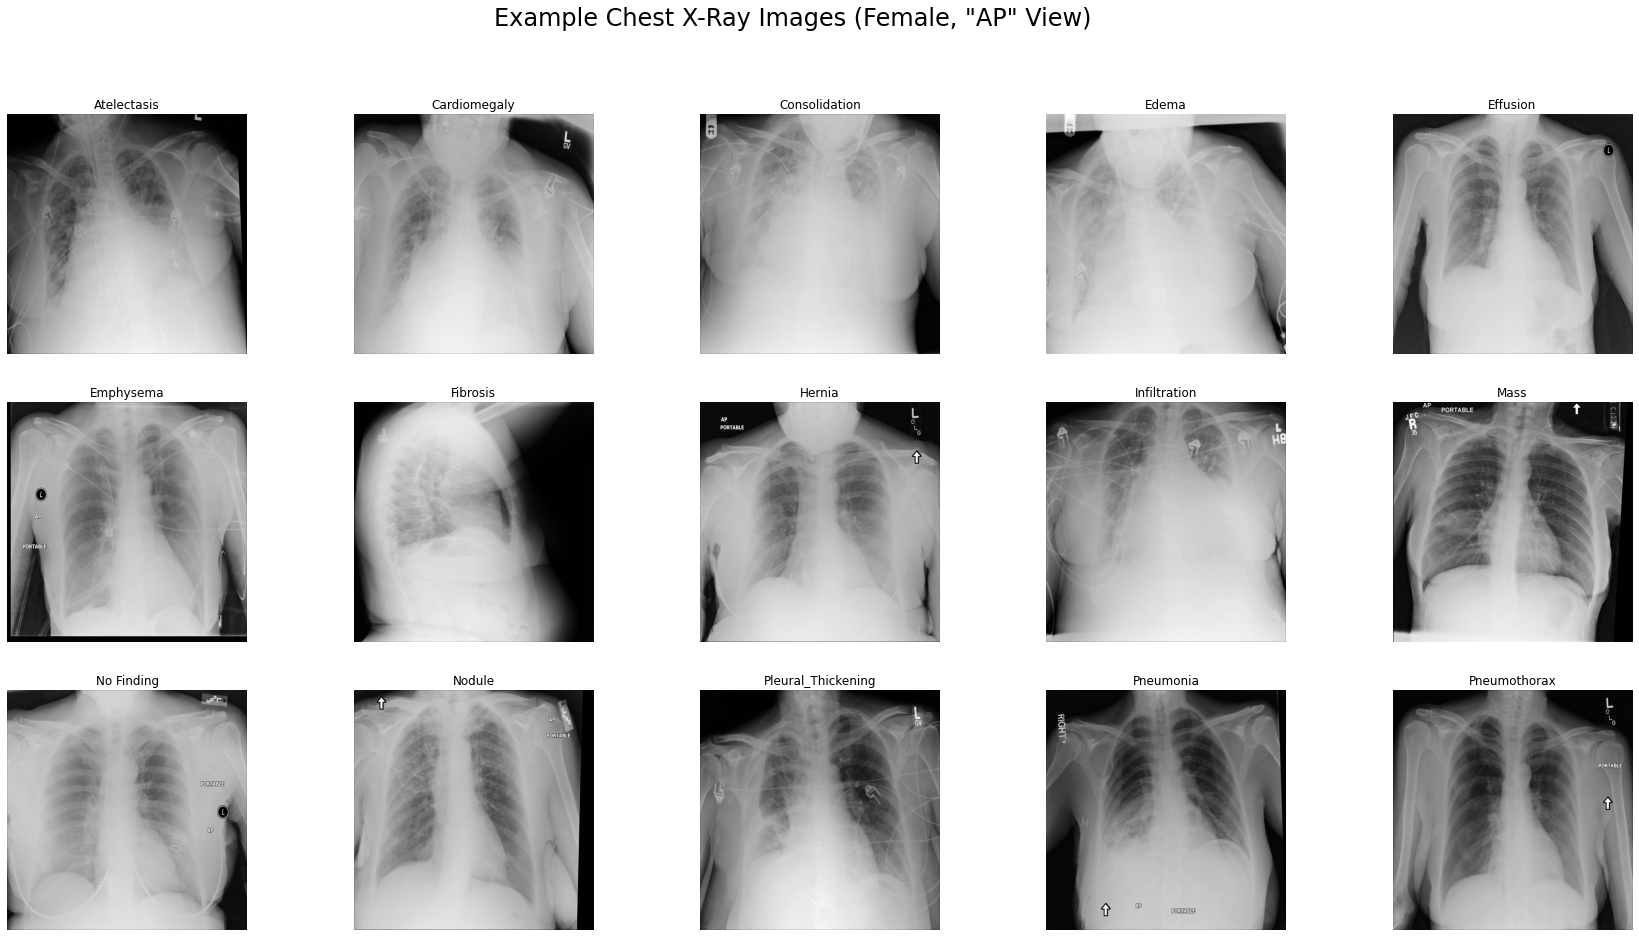

In [34]:
fig, axes = plt.subplots(3, 5, figsize=(30, 15))
axes = axes.ravel()
fig.suptitle('Example Chest X-Ray Images (Female, "AP" View)', fontsize=24)

i = 0
for label in mlb.classes_:
    img_id = mdf[(mdf['Finding Labels'] == label) & (mdf['View Position'] == 'AP') & (mdf['Patient Gender'] == 'F')]['Image Index'].iloc[0]
    xray = img.imread(data_path + img_id)
    axes[i].imshow(xray, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
    i += 1

---
# Data Wrangling Code - Condensed
The data wrangling code below is meant to be copied & pasted into new notebooks. One notebook will be created for each classification model.

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import MultiLabelBinarizer

In [36]:
# Data Wrangling
df = pd.read_csv('/Volumes/T7/mec-capstone-data/nih-chest-x-ray/Data_Entry_2017.csv')
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x','y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Fix patient age typos
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

df = df[df['Patient Age'] != -1]
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Binarize
mlb = MultiLabelBinarizer()
temp = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(temp, columns=mlb.classes_)
      
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 7)
Binarized DataFrame shape = (112117, 22)
